In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
import numpy as np
import torchvision
from resnet import *
import cvxpy as cp
# from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier, MLPRegressor
import os
import copy
from scipy.spatial.distance import cdist

In [2]:
def compute_w_opt(C_yy,mu_y,mu_train_y, rho):
    n = C_yy.shape[1]
    theta = cp.Variable(n)
    b = mu_y - mu_train_y
    objective = cp.Minimize(cp.pnorm(C_yy*theta - b) + rho* cp.pnorm(theta))
    constraints = [-1 <= theta]
    prob = cp.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    # The optimal value for x is stored in `x.value`.
    # print(theta.value)
    w = 1 + theta.value
    print('Estimated w is', w)
    #print(constraints[0].dual_value)
    return w

In [3]:
def w_comp(nc,n,m,DpX,DqX,fp,fp_vec,DpY):
    mm = m
    predict_p = np.zeros((n,nc))
    predict_q = np.zeros((mm,nc))
    predict_p[np.arange(n),fp.predict(DpX).astype(int)] = 1
    predict_q[np.arange(mm-1),fp.predict(DqX[0:mm-1]).astype(int)] = 1
    g_p = np.mean(predict_p,axis=0)
    g_q = np.mean(predict_q,axis=0)
    g_p_vec = np.mean(fp_vec.predict(DpX),axis=0)
    g_q_vec = np.mean(fp_vec.predict(DqX[0:mm-1]),axis=0)
    T = np.zeros((nc,nc))
    T_vec = np.zeros((nc,nc))

    for i in range(n):
        T[fp.predict(DpX[i].reshape(-1, 1)).astype(int),DpY[i].astype(int)] += 1/n
        T_vec[:,DpY[i].astype(int)] += fp_vec.predict(DpX[i].reshape(-1, 1))[0]/n

    #SVD
    u, s_vec, vh = np.linalg.svd(T_vec, full_matrices=True)
    u, s, vh = np.linalg.svd(T, full_matrices=True)
    print('svd:',s[-1],s_vec[-1])

    w = compute_w_opt(T,g_q,g_p,1e-3)
    print('w',np.linalg.norm(w-iw))

    w_vec = compute_w_opt(T_vec,g_q_vec,g_p_vec,1e-3)
    print('w_vec', np.linalg.norm(w_vec-iw))
    return w, w_vec

In [4]:
def regressor(n,m,DpX, DpY_vec,DqX,DqY_vec):
    fp_vec = MLPRegressor(solver='lbfgs', alpha=1e-1, learning_rate = 'adaptive', learning_rate_init= 1e-3 , max_iter=5000, activation='relu', hidden_layer_sizes=(50, 200, 500, 200, 50)).fit(DpX, DpY_vec)
    loss_P = 0
    loss_P_error = 0
    loss_Q = 0
    loss_Q_error = 0
    for i in range(n):
        a = np.sum((fp_vec.predict(DpX[i].reshape(-1, 1))-DpY_vec[i])**2)
        loss_P += a
        loss_P_error += 1/2<a
    for i in range(m):
        a = np.sum((fp_vec.predict(DqX[i].reshape(-1, 1))-DqY_vec[i])**2)
        loss_Q += a
        loss_Q_error += 1/2<a
    print('fp_vec loss:',loss_P_error/n,loss_Q_error/m,loss_P/n,loss_Q/m)
    return fp_vec


In [5]:
def sampling(nc,n,m,Py,Qy):
    mu = np.arange(1,nc+1)
    Py_hat = np.random.multinomial(n, Py)
    Qy_hat = np.random.multinomial(m, Qy)
    Dset_p = np.random.normal(0,sigma,n)
    Dset_q = np.random.normal(0,sigma,m)

    DpX = np.zeros((n,1))
    DpY = np.zeros((n))
    DpY_vec = np.zeros((n,nc))
    j = 0
    for i in range(nc):
        DpX[j:j+Py_hat[i],0] = Dset_p[j:j+Py_hat[i]] + mu[i]
        DpY[j:j+Py_hat[i]] = DpY[j:j+Py_hat[i]] + i
        DpY_vec[j:j+Py_hat[i],i] = 1
        j = j+Py_hat[i]

    DqX = np.zeros((n,1))
    DqY = np.zeros((n))
    DqY_vec = np.zeros((n,nc))
    j = 0
    for i in range(nc):
        DqX[j:j+Qy_hat[i],0] = Dset_q[j:j+Qy_hat[i]] + mu[i]
        DqY[j:j+Qy_hat[i]] = DqY[j:j+Qy_hat[i]] + i
        DqY_vec[j:j+Qy_hat[i],i] = 1
        j = j+Qy_hat[i]
    return DpX, DpY, DqX, DqY, DpY_vec, DqY_vec


In [6]:
#set sizes
nc_max = 20
stor = np.zeros((10,5,nc_max))
stor_vec = np.zeros((10,5,nc_max))
iw_vec = np.zeros((10,nc_max))
nc_vec = np.zeros((10))
for epoch in range(10):
    for ite in range(5):
        nc = 20
        nc_vec[epoch] = nc
        n = 1000 * (epoch+1)
        m = 1000 * (epoch+1)
        nc_vec[epoch] = n
        #shift
        Py = np.zeros(nc) ; Py[0:int(nc):2] = 1/nc ; Py[1:int(nc):2] = 3/nc  ; Py = Py/np.sum(np.abs(Py))
        Qy = np.zeros(nc) ; Qy[0:int(nc):2] = 3/nc  ; Qy[1:int(nc):2] = 1/nc ; Qy = Qy/np.sum(np.abs(Qy))
        iw = Qy/Py
        iw_vec[epoch,0:nc] = iw
        #samples
        sigma = 0.3

        DpX, DpY, DqX, DqY, DpY_vec, DqY_vec=sampling(nc,n,m,Py,Qy)

        fp = MLPClassifier(solver='sgd', alpha=1e-2, learning_rate = 'constant', learning_rate_init= 1e-3 , max_iter=5000, activation='relu', hidden_layer_sizes=(50, 200, 500, 200, 50)).fit(DpX, DpY)
        print('fp score:',fp.score(DpX, DpY),fp.score(DqX, DqY))

        unique, counts = np.unique(fp.predict(DqX), return_counts=True)
        # print('dict:fp:', dict(zip(unique, counts))

        fp_vec = regressor(n,m, DpX, DpY_vec,DqX,DqY_vec)


        w , w_vec = w_comp(nc,n,m,DpX,DqX,fp,fp_vec,DpY)
        stor[epoch,ite,0:nc] = w
        stor_vec[epoch,ite,0:nc]= w_vec


fp score: 0.395 0.148
fp_vec loss: 0.116 0.324 0.16625728979830096 0.3750600127968492
svd: 6.555507555461601e-87 9.834989162621306e-05
Estimated w is [1.04282072 1.12085077 1.01812925 0.98225689 0.93575129 0.7244351
 1.03087076 1.24344989 1.26134878 1.36922331 0.99382084 0.32181886
 3.36262365 0.97442296 0.8206084  0.74387597 0.97183035 0.92456693
 0.98087937 0.92657835]
w 6.355547084470866
Estimated w is [2.14775792 0.33450058 3.08204561 0.59139725 2.63510999 0.33096757
 3.12563132 0.49885718 2.86590653 0.36545111 1.9079684  0.32747269
 3.27955814 0.12239743 3.80984564 0.38682478 2.3163343  0.80641944
 1.2627002  0.76683981]
w_vec 2.6203556585219223


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.707 0.247
fp_vec loss: 0.13 0.356 0.198002958045056 0.4303778059644448
svd: -0.0 0.0006902667231658064
Estimated w is [1.09061739 1.30736797 0.99579275 0.63030488 2.28571422 0.77838507
 0.94128379 0.97133865 1.04480631 1.267762   1.03048802 0.95964258
 0.86546828 0.49445129 1.22876659 1.30474641 0.92388233 0.81917521
 0.98075909 0.94471132]
w 6.378155086681942
Estimated w is [3.55048714 0.30680251 2.50931439 0.33206837 2.56304843 0.42768286
 2.34881538 0.45840837 3.87687903 0.48159334 2.5087186  0.29149458
 3.15607459 0.22551222 2.88805667 0.2686783  2.83024968 0.52685301
 2.44478797 0.42497453]
w_vec 1.6290037313367791


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.386 0.108
fp_vec loss: 0.129 0.404 0.1881259408245502 0.47797211319832356
svd: -0.0 0.0004033088490566204
Estimated w is [1.09570227e+00 1.29078870e+00 9.64571814e-01 6.54390069e-01
 9.39418802e-01 7.62013897e-01 5.04576623e-07 1.63844375e+00
 4.75130863e+00 1.12819940e+00 8.31480973e-01 6.37315871e-01
 9.56072999e-01 9.20249435e-01 9.76369769e-01 9.36002523e-01
 9.76369769e-01 9.12372887e-01 9.73416070e-01 9.29110548e-01]
w 7.091453923736682
Estimated w is [3.36122719 0.22261933 2.33927358 0.22665617 2.46219686 0.36316214
 3.95043421 0.67120938 3.04672351 0.90847424 4.06072487 0.47000735
 1.6815429  0.54467123 2.31771022 0.75159555 1.94817096 0.64058788
 1.77869449 0.40896226]
w_vec 2.914890855850412


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 5 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 6 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.461 0.142
fp_vec loss: 0.157 0.49 0.20891312113012792 0.5355739208538961
svd: -0.0 0.000282031820013131
Estimated w is [1.11364458 1.31253327 1.05791464 1.04923277 1.01064594 1.06376901
 1.02806155 1.17880061 1.03069123 0.98761373 0.99411813 0.72844491
 0.86456188 0.89167657 1.14058807 1.57892175 1.17265105 0.80628364
 0.91406301 0.25887783]
w 6.646957442611802
Estimated w is [2.6715435  0.24863546 3.76482967 0.49824406 3.00481194 0.40911481
 2.94778776 0.5114908  2.99506193 0.54161003 3.00433866 0.43347514
 2.00723943 0.90002283 2.0694762  1.00619011 0.77706939 0.86872483
 0.87960129 0.46409751]
w_vec 3.631456477926189


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 7 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 8 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.656 0.234


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.188 0.535 0.2539902875559997 0.5764971615541997
svd: 0.0 3.278935561210959e-07
Estimated w is [1.07325117 1.26753625 1.05614521 1.09329729 1.01570453 0.85690917
 0.98433697 1.08702859 1.02020148 0.78541141 0.93323826 1.5360422
 1.39159107 1.04347072 0.97397051 0.95915464 0.99017844 0.96632074
 0.95803387 0.41776447]
w 6.620441726568184
Estimated w is [3.33477637 0.31458355 3.4422636  0.37773296 2.44504446 0.23521841
 3.91995266 0.37749068 2.50872762 0.55733787 2.16220075 1.05820697
 1.29326051 1.12172061 0.40673492 1.09352338 1.1615957  0.70178117
 2.02927449 0.39441543]
w_vec 4.277111895682865


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 9 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 10 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.5045 0.163


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.0875 0.1935 0.13767358299970534 0.27918526301614116
svd: 0.0 0.0012953901283682004
Estimated w is [1.08988267 1.34679549 1.00244771 0.79419741 0.92776373 0.81538329
 1.00841293 1.07796287 1.18116093 1.03673091 0.47554635 0.86557874
 3.29152818 0.45927174 0.93598091 0.99045445 0.99756729 0.99153071
 0.99667096 0.992009  ]
w 6.485966449819289
Estimated w is [4.01078493 0.32940141 3.10164128 0.33123626 2.26212449 0.35674946
 3.21395837 0.45998935 2.66788548 0.42471912 2.62411512 0.16281665
 3.47989064 0.31344597 2.80792843 0.23148477 3.86630075 0.40822191
 2.54236053 0.36581755]
w_vec 1.781126564085278


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 11 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 12 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.506 0.1945


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.149 0.3925 0.19544590691254937 0.43374014175055015
svd: 0.0 1.3949013115584234e-05
Estimated w is [1.19897938 1.54451241 1.08619977 0.61768715 2.34732314 0.99391967
 0.95942855 1.10569165 1.03459046 0.9386007  0.98206997 0.73499072
 0.91971115 0.80274004 0.97239914 0.94029018 1.00720284 1.01739896
 0.95232321 0.84241867]
w 6.360687322428786
Estimated w is [3.04928499 0.3098584  3.81006836 0.34011013 2.87654039 0.24321009
 4.08173827 0.23060083 3.03310846 0.37562579 3.61899072 0.4795516
 1.53944962 1.17848371 0.04689398 0.89073445 1.74136026 1.21980144
 0.68882294 0.5859516 ]
w_vec 4.682424563352749


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 13 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 14 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.4875 0.2315


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.1225 0.293 0.18287310279233698 0.358744449768546
svd: 0.0 0.000996279120642508
Estimated w is [1.0468204  1.15909659 2.89655172 0.35083931 3.78628733 0.05283683
 0.96295319 0.99438738 1.1714675  1.1975285  0.86462984 1.15830762
 1.23657731 1.03287656 0.97029933 0.82196581 0.93113903 0.83496379
 0.92334264 0.80506869]
w 6.012184307290692
Estimated w is [3.85192398 0.34646361 2.7459309  0.45973925 2.69296953 0.28177983
 2.34354637 0.43340872 2.71200996 0.37591672 2.91319676 0.31440834
 2.7649699  0.40491326 2.8358199  0.31271795 2.41329968 0.52065332
 1.99653654 0.4712278 ]
w_vec 1.7117230213266519


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 15 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 16 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.645 0.2185


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.128 0.326 0.1913114497668158 0.4002831708101885
svd: -0.0 0.0001337124290733637
Estimated w is [1.10794014 1.33460889 1.06439315 1.04698953 1.01319882 1.0266298
 0.98675432 0.9337096  0.95981336 0.89049573 1.03672223 1.20238583
 0.95088181 0.73405896 1.05106213 1.08813303 0.95181558 0.87150683
 0.95449254 0.85901436]
w 6.665969815402771
Estimated w is [2.74121433 0.42812309 3.10396395 0.36425265 3.46369381 0.35421809
 3.04855549 0.35206152 2.17178494 0.33941394 3.29676701 0.60390096
 1.23776571 0.94624635 1.06344143 0.633639   2.27208182 0.5569634
 2.20289675 0.44194139]
w_vec 3.1147632354167674


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 17 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 18 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.4385 0.128


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.115 0.327 0.17107294195931563 0.4066091626430783
svd: 0.0 0.00015434767368241497
Estimated w is [1.08863983 1.2642059  1.02386223 0.86612    0.96824593 0.97159856
 0.99581151 1.21202092 1.07592111 0.52279702 0.77562935 1.03729448
 3.46904999 0.88162704 0.97226961 0.90800674 0.94013509 0.8014408
 0.93890605 0.79253135]
w 6.410783832290409
Estimated w is [2.87283438 0.22713033 3.42472781 0.28354527 2.58639435 0.3714063
 2.63268799 0.42402476 3.50604762 0.37564866 3.62102264 0.33986509
 3.29263347 0.37132687 2.88370862 0.6437775  2.64302849 0.19127349
 3.80988354 0.24053909]
w_vec 1.47603537350806


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 19 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 20 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.6673333333333333 0.24033333333333334


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.09633333333333334 0.25933333333333336 0.16686657264044866 0.34955617444656584
svd: 9.68953665907184e-67 0.002174577267131352
Estimated w is [1.07728233 1.19845674 3.51921368 0.57729896 0.88327423 0.72395561
 1.8        0.85025564 0.98147572 1.0095284  0.97439205 0.77640827
 1.06288594 1.36915803 0.98746808 0.44082686 2.64296881 1.41197789
 0.76031403 0.18907575]
w 5.929664519060524
Estimated w is [3.21849587 0.38258962 3.28305989 0.29939054 3.16946349 0.31221958
 2.32266758 0.45629137 2.80533444 0.35548389 2.72174798 0.37279125
 2.00038687 0.34546827 4.13760508 0.35587289 3.46622586 0.24256962
 3.10452466 0.25479309]
w_vec 1.813448435090867


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 21 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 22 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.5556666666666666 0.17833333333333334


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.09866666666666667 0.25666666666666665 0.17989779989222923 0.374705953039303
svd: 0.0 0.00012034676169649666
Estimated w is [1.17760258 1.44399783 1.06649395 0.69927845 2.         0.98808511
 1.2        0.87279581 0.97768763 1.04000617 1.01391146 1.0882082
 1.03345513 0.97283414 0.98669748 0.96802204 1.05928291 1.00408853
 0.84855914 0.58778405]
w 6.335023425658799
Estimated w is [3.02299308 0.32184188 2.80840801 0.23694581 3.22448931 0.40432332
 3.08534022 0.32164822 3.09440309 0.39161881 2.73038369 0.3765998
 2.93720905 0.319088   2.93202879 0.74974804 1.20613117 0.66301336
 2.62047262 0.28748871]
w_vec 1.9624860167257154


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 23 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 24 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.5836666666666667 0.201


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.12766666666666668 0.3253333333333333 0.1900632116872703 0.40632970589098105
svd: -0.0 2.1368712312555e-05
Estimated w is [1.03998719 1.13388332 0.99793704 0.90183742 1.04758141 1.28711194
 1.01720236 0.90700125 1.00536336 1.03010046 0.96473799 0.89087386
 0.93337634 1.01260435 2.42677078 0.62320703 0.98104433 0.95129363
 0.97914762 0.9473774 ]
w 6.385711538033084
Estimated w is [2.87101341 0.32314443 2.98905268 0.2406684  3.78701829 0.39466466
 3.62640872 0.21988119 3.15462875 0.43438416 2.32634786 0.43832864
 2.53298961 0.71126773 1.00551605 0.87031372 1.54435015 0.89615537
 1.29803763 0.57332196]
w_vec 3.401473504810744


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 25 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 26 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.6906666666666667 0.30533333333333335


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.162 0.462 0.22455546049752176 0.5511250843332296
svd: -0.0 2.28783102424244e-05
Estimated w is [1.00607341 1.02343615 2.51362253 0.27752763 2.99496946 0.18415746
 3.60479477 0.53049345 0.96982018 1.04748432 1.01056704 1.03626156
 1.01604066 0.92767027 0.71137133 1.22013876 2.37275398 0.80931074
 0.87213457 0.59463588]
w 5.452691248436732
Estimated w is [3.82556916 0.32527478 2.50373899 0.27745698 2.95480344 0.32900746
 3.30946932 0.33933209 2.65454395 0.82868445 0.87696046 0.82634208
 1.64881567 0.91170272 1.67705682 0.84487499 1.29579083 1.02839809
 0.45010658 0.73268682]
w_vec 4.512749684967736


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 27 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 28 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.5303333333333333 0.18266666666666667


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.16533333333333333 0.5196666666666667 0.2341922277896188 0.5913463462827698
svd: 0.0 5.801921719929357e-06
Estimated w is [1.10729652 1.40469946 1.0389036  0.54556619 2.65060403 0.92769574
 0.92981641 0.91468182 0.96695073 0.8938912  0.96932379 1.29914736
 1.10997802 0.83878098 0.93685084 0.83215491 0.88559759 0.72171398
 3.29587345 0.38461539]
w 6.022358092948976
Estimated w is [3.52851772 0.26860274 3.43101446 0.21913791 3.22755654 0.29230643
 3.24474596 0.28021384 2.60122882 0.77350343 0.6778743  0.94937081
 1.46884363 0.70452885 2.38607685 0.88535382 0.66997833 1.12369818
 1.04668084 0.67376876]
w_vec 4.457795912837243


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 29 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 30 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.643 0.2805


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.149 0.3875 0.2186142782707489 0.46108115959890233
svd: 0.0 1.994413511360168e-05
Estimated w is [1.03662423 1.10177853 2.68362838 0.50553037 2.23016533 0.31578452
 3.21428571 0.75652041 0.96442157 1.05336762 1.00948552 1.01366168
 0.98313575 0.58792041 0.84556622 1.43090338 1.40428435 0.71780914
 0.86297073 0.62649366]
w 5.639667177539077
Estimated w is [3.22855881 0.34712787 2.66070653 0.4243266  2.43495097 0.35917914
 2.98640144 0.26793025 2.8032551  0.51107728 2.188207   0.55843015
 2.82999376 0.2618366  3.16001449 0.21849538 3.35768058 0.63094397
 0.46899821 0.76521817]
w_vec 2.8569260459294354


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 31 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 32 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.7265 0.449


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.15575 0.38475 0.19998896172177497 0.41421686428166
svd: 0.0 0.0008487607171811625
Estimated w is [3.10512257 0.301854   3.39648356 0.30542465 2.91331087 0.64972914
 1.89766285 0.40492301 2.74713187 0.73366848 0.91438047 1.01260592
 0.99347464 0.79914887 0.94235505 0.8928881  0.96400034 0.87541082
 0.98185328 0.96456942]
w 4.922803492706923
Estimated w is [2.95465526 0.33707258 3.50005669 0.36007709 2.67265667 0.48952406
 2.57455979 0.3210614  2.83113641 0.37698614 3.04433381 0.30433943
 2.17372478 0.37032355 2.94021718 0.39176279 3.52091864 0.25989762
 2.26567815 0.46527699]
w_vec 1.4571347139131283


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 33 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 34 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.54475 0.27325


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.099 0.225 0.16499198615574426 0.30701993551643847
svd: 0.0 0.0016860291609229327
Estimated w is [1.03157195 1.09594746 2.58434737 0.34725254 2.70217172 0.32072033
 2.49326473 0.38571949 1.14820511 1.1935158  0.38976397 1.36410921
 2.79898739 0.27722772 0.98499337 0.9481816  0.98224745 0.9538303
 0.9851549  0.95205491]
w 5.513903165240629
Estimated w is [2.92970083 0.42370846 2.65111441 0.37172193 2.5829278  0.35288884
 2.59514068 0.27001334 3.14224687 0.42938521 2.56657499 0.41354454
 3.35702714 0.34862297 3.01221393 0.29868922 2.33834795 0.42442099
 3.08279112 0.37675399]
w_vec 1.13409853461638


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 35 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 36 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.70275 0.3585


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.0845 0.1725 0.15478109922567376 0.26960852538039337
svd: 0.0 0.005977491142444397
Estimated w is [0.97928609 0.94385207 3.662729   0.17719507 2.82264099 0.42899542
 3.45       0.42538871 1.84841321 0.47495371 2.36816201 0.48018611
 1.01648676 1.13093761 0.98272083 0.98170506 2.52226942 0.63357957
 0.85214239 0.61462292]
w 4.5835871089672
Estimated w is [3.04320502 0.30669032 3.06176397 0.29379056 2.95605824 0.3482021
 3.80572159 0.29965701 2.58475928 0.3345226  2.24156513 0.41747359
 3.38752443 0.32991583 3.01274406 0.32215289 2.56018475 0.24573448
 2.55667075 0.35043403]
w_vec 1.4012766074003538


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 37 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 38 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.697 0.274


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.13025 0.34475 0.19955359845592552 0.42347332787465575
svd: 0.0 4.0214207440182787e-05
Estimated w is [0.98696547 0.95760521 2.77727172 0.56365242 2.54545454 0.46721675
 2.36977065 0.68825646 0.98519897 1.28946643 1.07581957 0.90054289
 0.97101185 0.92646972 1.02202918 1.15041574 1.04177402 0.78232496
 0.89845806 0.72125389]
w 5.651723975104086
Estimated w is [3.10184903 0.26103273 3.129006   0.31956624 3.47971537 0.31861718
 2.57412341 0.33703602 3.15272964 0.46243615 2.79972518 0.52236647
 2.53250178 0.57973444 1.97565441 0.82818454 0.19369759 0.81844614
 2.76390717 0.40276984]
w_vec 3.210086711346419


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 39 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 40 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.7506 0.3954


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.0872 0.2164 0.1532928328920581 0.3027625563870545
svd: 9.820390983461183e-51 0.0014725404155910304
Estimated w is [2.55555544 0.54339982 2.60548263 0.30771031 2.6536364  0.45237267
 2.66666646 0.39093271 3.1621369  0.64507004 0.98005296 1.15023989
 1.0100194  0.76003114 1.05277309 1.34967388 1.07045087 0.63216371
 0.94622632 0.83293665]
w 4.771194894057942
Estimated w is [2.94551624 0.38061098 2.74489815 0.28696342 2.73726546 0.36365417
 3.3567636  0.29500761 3.05567866 0.39769837 3.08399712 0.3119889
 3.17578271 0.36476632 2.94822857 0.37260671 2.74812054 0.37967002
 2.98154414 0.35654799]
w_vec 0.6232679421934654


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 41 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 42 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.8394 0.536


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.1278 0.3148 0.17960361572600494 0.3565955213123385
svd: -0.0 0.001980462637034755
Estimated w is [2.20124033 0.40782884 2.5363235  0.29581089 3.48796603 0.31572423
 3.1251372  0.40196248 3.28       0.38562406 2.55305539 0.30862421
 3.84272833 0.39742386 0.92682334 0.98464934 0.96330803 0.84237273
 0.99765371 1.00521425]
w 3.9629392524518443
Estimated w is [2.25768212 0.36872853 2.65119088 0.30568348 3.24039759 0.33609633
 3.27787044 0.39206849 3.11399184 0.42414343 2.56987374 0.39267578
 2.89202395 0.33203125 3.10626336 0.29590794 2.97872783 0.32331046
 3.09318723 0.3728582 ]
w_vec 1.028641955354751


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 43 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 44 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.5546 0.2692


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.1278 0.3242 0.1888337184485578 0.4090436181227937
svd: -0.0 1.0179571279509818e-05
Estimated w is [1.03418078 1.10176203 2.53331436 0.35592233 3.43138529 0.28427127
 2.75371537 1.21644903 0.0242509  0.66127758 2.20497022 0.49166502
 0.73038868 1.09524043 2.84471989 0.31613505 3.02850575 0.68509181
 0.90127731 0.67040687]
w 5.071577916271184
Estimated w is [3.30196932 0.33501144 2.76427754 0.32142604 3.27664215 0.27131607
 2.8707451  0.34474137 2.74145858 0.370876   2.85861347 0.35993725
 2.71978866 0.44649999 2.38063687 0.42268897 3.05652005 0.28751288
 3.19999244 0.33322991]
w_vec 0.9280470878518511


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 45 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 46 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.7016 0.3974


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.1572 0.4184 0.21746744425899114 0.48537935138456006
svd: -0.0 1.7387887189412228e-05
Estimated w is [3.30908996 0.23641204 3.3962218  0.30989958 3.02302384 0.36488881
 2.735342   0.27527218 2.94494551 0.31951829 2.93941195 0.35110336
 1.00990889 1.13590994 2.01178373 1.30347852 0.71392752 0.56346901
 0.96272862 0.86631176]
w 4.07192778891123
Estimated w is [3.31628438 0.26937711 3.17372501 0.37565779 2.8731772  0.432761
 2.50449332 0.42522686 2.3937368  0.50406959 2.27145951 0.50315702
 2.57249181 0.59702464 2.55607558 0.49402674 2.13974129 0.88731026
 0.97121997 0.68227938]
w_vec 2.6706162662313315


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 47 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 48 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.5532 0.3886


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.1606 0.4028 0.22979929449964262 0.4811968836941891
svd: 0.0 1.0040076434043556e-07
Estimated w is [2.72856103 0.29454985 2.75579134 0.3590753  3.41341055 0.27895376
 3.5440402  0.22790543 3.29767516 0.35296104 2.49079564 0.3908046
 2.41936058 0.98096835 0.73389434 0.41838845 0.96791959 0.9113422
 0.96989382 0.91204618]
w 3.9732554634347585
Estimated w is [2.70020497 0.31395312 2.70587049 0.42792405 3.20302288 0.32062289
 3.18238078 0.31235467 3.28136137 0.74912802 0.61843049 0.71974799
 2.97712862 0.50348572 0.79345269 0.99808384 1.77719395 0.44011441
 2.85976435 0.26445477]
w_vec 3.633912539770928


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 49 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 50 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.8306666666666667 0.5328333333333334


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.08683333333333333 0.17283333333333334 0.14929606778749563 0.2708095183402776
svd: 9.864459676876984e-20 0.005863520957531913
Estimated w is [2.84117784e+00 3.01705005e-01 3.47387975e+00 1.99011493e-01
 3.40143979e+00 2.58486914e-01 3.35974389e+00 3.04449646e-01
 2.89808789e+00 3.66927640e-01 3.12029893e+00 8.80802682e-01
 8.32201997e-01 5.25572126e-01 3.18572071e+00 2.18695806e-09
 3.59318063e+00 2.73324781e-01 3.05201172e+00 3.13472003e-01]
w 2.476290652697882
Estimated w is [2.83102764 0.31224913 3.25292185 0.27950971 3.27858182 0.30380711
 3.23575723 0.30178137 3.03015903 0.31830619 3.31026653 0.33886184
 2.55595986 0.31627481 3.30023165 0.26774738 2.65269084 0.32959732
 3.04888741 0.31181903]
w_vec 0.8624060497163917


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 51 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 52 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.7303333333333333 0.4505


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.2795 0.5983333333333334 0.35133675666315134 0.661783730593128
svd: 0.0 4.010972001717741e-19
Estimated w is [2.8997999  0.32063537 2.76992079 0.3548693  2.65906692 0.37920735
 3.20731558 0.30988053 2.58915148 0.5450579  0.73536024 1.1029946
 1.87640649 0.7048176  0.81353621 1.20886433 2.30706641 0.82316823
 0.80308687 0.5151522 ]
w 4.322879664643335
Estimated w is [2.90989735 0.33449757 2.7520861  0.33068316 2.78649899 0.44535841
 2.59716449 0.69224853 0.85735826 1.0942005  1.17556172 1.14943453
 0.95815533 1.08166776 0.91507324 1.26527743 0.9408571  0.65513636
 0.87128762 0.77847116]
w_vec 5.34799120739226


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 53 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 54 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.715 0.49383333333333335


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.11583333333333333 0.2853333333333333 0.18143176612489106 0.38149776355206394
svd: 0.0 4.489778224304911e-07
Estimated w is [3.56990372 0.29367258 3.23928664 0.28794687 3.21658913 0.31506279
 3.68635511 0.30024652 2.62660093 0.3758109  2.18198439 0.57042402
 3.49858659 0.13745371 0.58989881 1.24135632 2.51060152 0.85722211
 0.86714433 0.6135357 ]
w 3.719315077820752
Estimated w is [3.4889082  0.3560543  3.03858827 0.33139635 3.16586589 0.34600442
 3.42081882 0.35101436 2.74106316 0.30973259 2.7543453  0.42270774
 3.04683442 0.35101228 2.66699337 0.42890878 2.46738349 0.94799516
 0.41900556 0.75744373]
w_vec 2.8648696737846215


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 55 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 56 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.8288333333333333 0.5703333333333334


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.14433333333333334 0.3953333333333333 0.19863426030635192 0.4430634441333628
svd: 7.841758541223634e-21 0.00014869264774527652
Estimated w is [3.2550207  0.33774335 2.57695355 0.32071491 3.13914728 0.30811377
 2.81936362 0.19544062 4.26227222 0.40297666 3.14103539 0.45286126
 2.78317438 0.81222753 0.90279383 0.50770343 2.45454532 0.64258778
 2.36070685 0.3525641 ]
w 2.730465163492655
Estimated w is [3.20152604 0.28597212 2.88606295 0.30125488 3.07524076 0.33333948
 2.6761015  0.39598806 3.50696891 0.59485054 2.58567536 0.84417935
 0.39186031 0.78536682 1.79763317 0.59150104 2.32968865 0.7761499
 0.89850833 0.72708584]
w_vec 3.8295138533573847


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 57 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 58 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.8131666666666667 0.4716666666666667


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.07916666666666666 0.1595 0.15032103849777861 0.2642931196937213
svd: -0.0 0.006836579199836874
Estimated w is [0.93770722 0.82538626 3.07556361 0.31156207 3.65231385 0.26959146
 3.35185956 0.26190323 3.22442882 0.32201598 3.18408661 0.4190393
 0.97873943 1.13544401 1.06547753 1.22980798 1.04672675 0.89932549
 0.91979642 0.5908785 ]
w 4.791209110850756
Estimated w is [3.01424947 0.28249709 2.90688114 0.33525139 3.4452222  0.32707074
 3.2457042  0.31689891 2.84571809 0.40152596 2.89492825 0.30984476
 3.66322865 0.37606877 2.90334894 0.41281222 2.82386434 0.29656983
 2.86399448 0.31722342]
w_vec 0.9049303827883582


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 59 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 60 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.8747142857142857 0.6614285714285715


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.1392857142857143 0.391 0.1951160092485841 0.4436642508385905
svd: 0.0 0.0003262650514769684
Estimated w is [2.87277851 0.40130566 3.33035293 0.34561736 2.65670674 0.32934532
 3.10491016 0.35676444 2.82563488 0.28673148 2.96336568 0.4300511
 2.93687859 0.41483013 2.47723668 0.9433749  0.92235271 1.09716785
 0.98554027 0.47789749]
w 3.1524353478372973
Estimated w is [2.88991721 0.40569085 3.34943293 0.35821636 2.649453   0.30277442
 3.09580923 0.38141407 2.71035736 0.35354048 2.74007118 0.47486536
 2.95442763 0.44521054 1.99117299 0.72180296 1.80324265 0.76746054
 2.34869313 0.42837058]
w_vec 1.919489855324664


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 61 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 62 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.8541428571428571 0.6751428571428572


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.119 0.26671428571428574 0.1725100782223527 0.32308897562561767
svd: 0.0 0.002258680391127095
Estimated w is [3.03762547e+00 3.02618640e-01 2.74216806e+00 2.55534643e-01
 3.17890938e+00 3.58451278e-01 3.33885286e+00 3.34935108e-01
 2.93087440e+00 3.90476420e-01 3.61879523e+00 1.98390066e-01
 3.39932161e+00 1.78016890e-01 3.81305405e+00 1.94879102e-01
 3.40387017e+00 5.78367687e-10 9.98978494e-01 9.96649019e-01]
w 2.4927129032302004
Estimated w is [2.99494365 0.31169962 2.75765379 0.25645498 3.19974877 0.35933609
 3.34768997 0.30178583 3.0553105  0.35260354 3.59706574 0.24890153
 3.37489915 0.28353864 3.01583643 0.45451399 2.28944205 0.36916996
 3.19127257 0.2877823 ]
w_vec 1.139053565598761


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 63 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 64 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.8538571428571429 0.6475714285714286


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.16757142857142857 0.45271428571428574 0.23772246308684103 0.5370186792713829
svd: 1.1700210375411244e-35 1.4652330972632001e-05
Estimated w is [3.35644907 0.26942613 3.70102839 0.32176489 3.52035992 0.37259673
 3.30259745 0.47101771 2.50263475 0.39566873 2.79417315 0.3924088
 2.83816358 0.17609259 2.57306509 0.8012816  0.91012693 0.5975179
 0.97125825 0.92609042]
w 3.2648655595538587
Estimated w is [3.27963027 0.30777244 3.5882634  0.41222305 3.18989466 0.34717078
 3.47998989 0.49388989 2.26357122 0.73051397 1.39589425 1.07653967
 0.64742545 0.7956882  1.02931345 0.95839755 1.06287552 0.74158963
 2.38422899 0.40518852]
w_vec 4.34456972462844


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 65 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 66 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.8207142857142857 0.5291428571428571


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.14842857142857144 0.3862857142857143 0.20151193543519283 0.4189747651810835
svd: 0.0 0.00010551974795933487
Estimated w is [2.47338621 0.32927395 2.92760264 0.33077915 3.04115252 0.38102626
 2.86669116 0.34733888 3.01039192 0.71438036 0.92909185 1.23539971
 1.05007404 0.79869745 1.01795357 1.24717241 1.08106894 0.3747747
 0.99116236 1.02137698]
w 4.7463083088016305
Estimated w is [2.50228119 0.30815766 2.93883495 0.32872682 3.05601435 0.39742248
 2.82044405 0.35323092 3.03945374 0.2841457  2.92539741 0.3503451
 3.52096101 0.37709078 2.94821223 0.43105788 2.14377856 0.72589215
 1.09950416 0.67712544]
w_vec 2.2813756009665025


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 67 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 68 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.788 0.535


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.17242857142857143 0.459 0.24696617702536378 0.5558280813107348
svd: 3.0857383770646907e-50 1.3331434571706917e-18
Estimated w is [2.95500182 0.31498723 3.44771851 0.27137084 3.24385232 0.29683985
 2.73130838 0.32171015 2.993325   0.21647994 3.31112861 0.31670339
 0.95564378 0.93988472 0.95240493 0.88282047 1.1048804  1.18737013
 0.96275082 0.9000496 ]
w 4.276077972691
Estimated w is [2.97641834 0.36788608 3.18987642 0.32517995 3.12538858 0.32129098
 2.65915046 0.35243772 2.87695292 0.35598524 2.2667279  0.6964464
 1.31678429 0.93671093 1.35584661 0.80183451 1.07910831 1.13996986
 0.32161454 0.88526635]
w_vec 4.335245374740019


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 69 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 70 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.852875 0.62375


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.167625 0.441125 0.21667514870888183 0.4757922237524967
svd: 1.36065451652363e-37 0.00023470761270766774
Estimated w is [2.66103863 0.43673942 3.06032635 0.3332072  3.0404292  0.33279518
 3.18278937 0.25873345 3.48467105 0.38986488 2.63120923 0.42041394
 3.07442335 0.34132021 2.82686019 0.6012039  0.94694323 1.08588756
 0.97556075 0.46832162]
w 3.0914108576912906
Estimated w is [2.64960315 0.43694354 2.91244493 0.41918871 3.05449362 0.31177685
 3.1055019  0.36634301 2.96559496 0.62344372 1.55713636 0.84047503
 1.66856099 0.81019583 1.52940181 0.49992618 2.90564663 0.34290758
 2.60832022 0.35405047]
w_vec 2.634763155892527


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 71 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 72 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.81525 0.523


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.115375 0.274125 0.17947973951915264 0.34355882266485616
svd: 0.0 0.0012839479712168345
Estimated w is [2.68875552e+00 3.58969479e-01 3.12176072e+00 3.16959130e-01
 2.59916756e+00 4.19865109e-01 2.84536210e+00 3.26287938e-01
 2.72879842e+00 3.41707090e-01 2.20961641e+00 2.89935215e-07
 5.32215788e+00 5.23901078e-02 9.46659799e-01 9.81444082e-01
 1.01609614e+00 1.05228675e+00 1.00232514e+00 1.00634841e+00]
w 4.485331773362394
Estimated w is [2.73085952 0.32665153 3.18938093 0.31398598 2.56285338 0.41251231
 2.94102937 0.32019373 2.57257267 0.30353841 2.87677903 0.33382399
 2.93303261 0.34017738 2.75199744 0.33492076 3.21582763 0.35619102
 3.23191658 0.33271168]
w_vec 0.821846619743557


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 73 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 74 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.73675 0.419


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.077375 0.17275 0.14165988334194252 0.2760203523871804
svd: 0.0 0.0070676843830075955
Estimated w is [2.73936850e+00 3.49032071e-01 2.94117161e+00 3.48431615e-01
 2.70358074e+00 3.88750218e-01 3.44534087e+00 5.94188976e-09
 4.82662018e+00 4.45725301e-01 2.56789541e+00 9.22810603e-01
 7.90357789e-01 1.06191472e+00 1.02267835e+00 7.63118323e-01
 9.30090406e-01 8.47307726e-01 9.51326641e-01 8.61355766e-01]
w 4.784144776688137
Estimated w is [2.73390289 0.36775494 2.88778712 0.31865248 2.84471016 0.35227999
 3.41726939 0.34795038 3.52591548 0.404845   2.99921177 0.30209083
 3.29195787 0.29631261 3.28731412 0.34624051 3.28304376 0.29796422
 2.99401213 0.3484394 ]
w_vec 0.9040096994998904


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 75 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 76 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.783625 0.552125


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.1835 0.498125 0.22727678042668473 0.523499027166273
svd: -0.0 1.1996437560835109e-11
Estimated w is [3.01119582 0.30432825 3.4732031  0.30430747 3.00411451 0.21033851
 2.88331773 0.39198926 2.53583448 0.44319398 2.5337558  0.97336293
 0.82756819 1.07513007 1.07197018 0.46666689 2.39927098 0.45486444
 2.96293613 0.34819983]
w 3.239523095293272
Estimated w is [2.96535422 0.31707196 3.4828105  0.32489758 2.90225132 0.27375431
 2.73072294 0.33274448 2.76632091 0.43756381 2.88375344 0.38012072
 2.89227874 0.34116076 2.9321313  0.74245609 0.68968813 1.01308437
 1.48587642 0.62593557]
w_vec 2.9602146112202226


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 77 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 78 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.833125 0.549


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.098625 0.21575 0.16307673359070343 0.30315902107245046
svd: 0.0 0.004782532640418166
Estimated w is [3.06256696 0.30319191 3.37766035 0.31376851 3.28536622 0.26464922
 3.57060032 0.28611971 3.03046339 0.36658813 3.10614861 0.33089764
 2.98901098 0.04298699 3.99999981 0.23337205 1.00925698 1.06178003
 0.97253687 0.91015708]
w 3.256768986738749
Estimated w is [3.11920293 0.33900036 3.06151945 0.3675258  3.23000382 0.29430125
 3.41750659 0.30367021 3.06602304 0.33488031 3.47093562 0.26875557
 2.86340328 0.27418944 3.05778884 0.33679333 2.7564649  0.38721547
 2.94870195 0.3184819 ]
w_vec 0.754782806824621


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 79 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 80 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.8702222222222222 0.6557777777777778


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.10133333333333333 0.24955555555555556 0.1630831633688346 0.3211846588019805
svd: -0.0 0.0039246227515715715
Estimated w is [3.35085532 0.32185984 2.99504152 0.35552297 3.0074355  0.34011628
 2.93191574 0.34623403 3.29762513 0.36407102 2.99720683 0.3285715
 2.78409022 0.44211685 2.98866367 0.83033909 0.95375837 0.93616631
 0.9319049  0.55951642]
w 3.0663479779204685
Estimated w is [3.40835507 0.31117423 2.99839197 0.35487621 3.0497385  0.32148319
 2.9887372  0.34845572 3.2529449  0.33470016 3.09658498 0.34028359
 2.73590987 0.40426579 3.27977746 0.32773061 2.84985791 0.30374428
 3.05624268 0.31838246]
w_vec 0.6510976565757844


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 81 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 82 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.4424444444444444 0.34855555555555556


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.159 0.4471111111111111 0.22161794863346843 0.5243362081248153
svd: 1.5573560016936363e-19 6.631476285964196e-09
Estimated w is [2.53817593 0.44482044 2.90736208 0.4399118  2.98754731 0.26896266
 2.94046433 0.36609232 3.02659547 0.29215683 2.56328675 0.68955098
 2.44871029 0.28840782 3.29636409 0.29367124 2.52219227 0.7432768
 0.92394236 0.77123495]
w 2.4224059580363564
Estimated w is [2.55539682 0.42880942 3.09599699 0.42187544 2.77429874 0.32659704
 2.931459   0.34980699 3.00774093 0.32404939 3.17560044 0.4124795
 2.21898612 0.90560887 0.41131283 1.10353403 1.26455865 0.7123594
 2.22127655 0.4848852 ]
w_vec 3.511955607246955


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 83 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 84 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.8314444444444444 0.6246666666666667


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.14377777777777778 0.3631111111111111 0.20198824206610733 0.4167537445121062
svd: 0.0 0.00011585073794719976
Estimated w is [3.24693879 0.2619041  2.88849615 0.29139389 3.28831685 0.37130157
 2.86528418 0.33634538 2.58688686 0.32970322 2.74287042 0.28079024
 2.9993159  0.51304466 2.2259858  0.98117172 1.08010642 1.21810926
 0.85534268 0.32597086]
w 3.2468552131682893
Estimated w is [3.20138659 0.30514658 2.83765009 0.28143482 3.28355763 0.37632805
 2.85671892 0.36079484 2.47762732 0.31559664 2.95013256 0.23729533
 3.10204792 0.2786503  3.02531286 0.58883102 1.43532446 0.83753541
 1.91003421 0.54278052]
w_vec 2.114824720302281


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 85 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 86 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.8618888888888889 0.6177777777777778


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.07722222222222222 0.164 0.1440055054082219 0.26313200399607806
svd: 0.0 0.006968597308527768
Estimated w is [3.01137177 0.25339091 3.12553398 0.34008259 3.02846315 0.29024335
 3.4973952  0.39469425 2.94995488 0.32574428 3.60004584 0.29437445
 3.83529063 0.2530832  2.42729849 0.48413984 1.00929772 1.14184247
 0.97064283 0.73868286]
w 3.2548970656481937
Estimated w is [3.04092044 0.27187409 3.04347393 0.33209258 3.07837737 0.30301661
 3.41705857 0.34913559 3.12474239 0.31480795 3.60851256 0.34727012
 3.46126205 0.27593514 2.57591117 0.35301297 2.64303804 0.35766504
 3.1914684  0.31360235]
w_vec 1.065991436776045


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 87 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 88 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.7053333333333334 0.5006666666666667


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.11344444444444444 0.2806666666666667 0.1749925253068165 0.36798406122628835
svd: 2.7509939788438214e-20 0.00021674034125895644
Estimated w is [2.85743471 0.33196937 3.14280379 0.25939007 3.2261871  0.28479572
 2.8933398  0.26189787 3.4109896  0.2664344  2.9299359  0.46156462
 2.16821071 0.4406988  1.01419022 1.18114718 1.85761722 0.73735937
 0.94238675 0.82433752]
w 3.4087660158210573
Estimated w is [2.83687248 0.34045264 3.06378907 0.29220215 3.23622974 0.29916592
 2.72140985 0.32641171 3.1890323  0.34700316 3.43083903 0.30585565
 2.5561127  0.30761473 2.81022026 0.45825814 2.01587168 0.59677142
 3.0016679  0.34313879]
w_vec 1.2948663233461917


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 89 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 90 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.8658 0.6425


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.1572 0.4511 0.22314752676062025 0.5247177186238215
svd: 0.0 6.768950788453626e-05
Estimated w is [2.87006714 0.27844277 3.0748322  0.32081006 3.17661627 0.31680363
 2.95679013 0.29136036 3.25371732 0.28347911 2.91233477 0.36101546
 2.93117899 0.28773511 3.39020182 0.42780666 0.98650658 1.04643181
 0.96345965 0.8675342 ]
w 3.049522507862907
Estimated w is [2.85352747 0.31095332 2.93641875 0.3621629  3.00585559 0.34858905
 2.90766713 0.33269508 2.84953648 0.42067219 2.45932473 0.34593025
 3.39417313 0.34096378 2.83717587 0.63413375 1.4674414  1.03253477
 1.12984753 0.56551011]
w_vec 2.649489655336325


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 91 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 92 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.8383 0.5561


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.1333 0.3531 0.20084544929961348 0.44071589120379556
svd: 0.0 0.00011167153907920743
Estimated w is [3.03399567 0.34003687 2.79867765 0.32570631 3.29844263 0.28306916
 3.16012663 0.29523173 2.73552896 0.34013778 3.04481948 0.97672698
 0.8121581  0.57240081 3.06601475 0.86693683 0.92394455 1.10769498
 0.99922525 0.42705456]
w 3.8341691672030866
Estimated w is [3.05646853 0.33464961 2.809792   0.29527052 3.39703143 0.30486594
 3.00160185 0.29945206 2.79496196 0.3329112  3.13513953 0.397333
 2.90138925 0.73883232 0.98173952 1.03521437 1.34312451 0.84278266
 1.71459806 0.51381069]
w_vec 3.1136126430297173


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 93 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 94 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.8667 0.6666


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.1182 0.2884 0.17498332490206497 0.3499774549775526
svd: 0.0 0.0005655117831373279
Estimated w is [3.07419881 0.26881014 3.4453866  0.33112014 2.81131917 0.35918271
 2.98349472 0.25798091 3.09992252 0.37339719 2.86870769 0.34855676
 3.06937843 0.29822289 3.35234144 0.43566307 2.48582626 0.87693007
 0.67519583 0.53877408]
w 2.5351085338697166
Estimated w is [3.01932934 0.27931416 3.48988342 0.32603578 2.84613386 0.36006447
 2.89775366 0.27863106 3.11528971 0.35905591 2.88964433 0.35808656
 2.99588667 0.29561333 3.33754261 0.30701408 3.04476045 0.29535785
 2.89927032 0.29686062]
w_vec 0.6624960174130499


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 95 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 96 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.74 0.5841


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.1796 0.4994 0.23781343700111124 0.5545739819158387
svd: 2.3927106625719005e-19 1.186309271962393e-11
Estimated w is [3.077991   0.27491648 3.38277283 0.23982448 3.07869952 0.27184317
 3.03178755 0.32370332 2.87535925 0.54307634 2.53855065 0.9024415
 1.27437318 0.67459038 1.55462773 1.2713763  0.49593393 0.43526995
 3.04589447 0.34782026]
w 3.6219473981355206
Estimated w is [3.109871   0.28762301 3.22222821 0.27468837 3.02355682 0.26699597
 3.09950207 0.30185016 2.8629463  0.70626719 1.19657625 0.84583228
 1.1303612  1.14836041 0.75350267 0.71972449 2.45217337 0.67439731
 2.07327541 0.51690834]
w_vec 3.7974349977048343


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 97 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 98 times so far.

  warnings.warn(msg, UserWarning)


fp score: 0.6898 0.4947


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


fp_vec loss: 0.1189 0.2898 0.16746682630232868 0.3333686168113742
svd: 2.1366932286018492e-50 0.002097787179174282
Estimated w is [2.90244795 0.31564027 2.82937533 0.31383213 3.20673102 0.2509689
 2.79406559 0.36325666 2.72228994 0.30813767 3.0478018  0.28697297
 2.89546664 0.41715566 0.93460622 1.57513327 1.55659505 0.84041735
 0.88707281 0.67065392]
w 3.599862638624549
Estimated w is [2.89316629 0.31620981 2.80380553 0.33670382 3.12332593 0.26177659
 2.82001624 0.3606026  2.85678335 0.27156538 3.04665822 0.31535619
 3.02947123 0.34634285 3.01782087 0.34610935 3.1747718  0.35880132
 3.06512677 0.31064725]
w_vec 0.4098447590001351


/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 99 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 100 times so far.

  warnings.warn(msg, UserWarning)


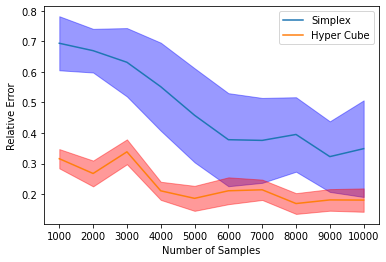

In [49]:
import matplotlib
import matplotlib.pyplot as plt


# Data for plotting
iw_vec_repeat = np.repeat(iw_vec[:, np.newaxis,:], 5, axis=1)
iw_vec_norm = np.linalg.norm(iw_vec,axis=1)

iw_vec_norm_repeat = np.repeat(iw_vec_norm[:, np.newaxis], 5, axis=1)

y = np.linalg.norm(stor-iw_vec_repeat,axis=2)
y_vec = np.linalg.norm(stor_vec-iw_vec_repeat,axis=2)


y_normalized = y/iw_vec_norm_repeat
y_vec_normalized = y_vec/iw_vec_norm_repeat

y_mean = np.mean(y_normalized,axis = 1)
y_vec_mean = np.mean(y_vec_normalized,axis = 1)

y_std = np.std(y,axis = 1)
y_vec_std = np.std(y_vec_normalized,axis = 1)



fig, ax = plt.subplots()

ax.plot(nc_vec.astype(int),y_mean)
ax.set_xticks(nc_vec)
ax.fill_between(nc_vec.astype(int), (y_mean-y_std/3), (y_mean+y_std/3), color='b', alpha=.4)

ax.plot(nc_vec.astype(int),y_vec_mean)
ax.set_xticks(nc_vec)
ax.fill_between(nc_vec.astype(int), (y_vec_mean-y_vec_std/3), (y_vec_mean+y_vec_std/3), color='r', alpha=.4)
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Relative Error')
plt.legend(('Simplex', 'Hyper Cube'),loc='upper right')
# plt.title('overlap')
# ax.set_xticklabels(nc_vec.astype(int))
ax.set_rasterized(True)
plt.savefig("Simplex_HyperCube_sampple.eps",format='eps', dpi=1000)

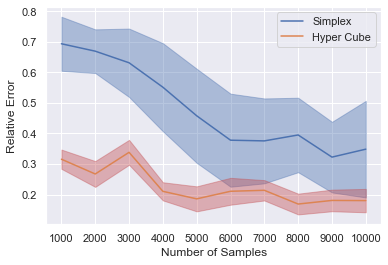

In [70]:
sns.set_theme()
import seaborn as sns
fig, ax = plt.subplots()


ax.plot(nc_vec.astype(int),y_mean)
ax.set_xticks(nc_vec)
ax.fill_between(nc_vec.astype(int), (y_mean-y_std/3), (y_mean+y_std/3), color='b', alpha=.4)

ax.plot(nc_vec.astype(int),y_vec_mean)
ax.set_xticks(nc_vec)
ax.fill_between(nc_vec.astype(int), (y_vec_mean-y_vec_std/3), (y_vec_mean+y_vec_std/3), color='r', alpha=.4)
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Relative Error')
plt.legend(('Simplex', 'Hyper Cube'),loc='upper right')
# plt.title('overlap')
# ax.set_xticklabels(nc_vec.astype(int))
# ax.set_rasterized(True)
sns.set_style(style='whitegrid')
sns.set_style('ticks')

# plt.savefig("Simplex_HyperCube_sampple.pdf",format='pdf', dpi=100)